# Topic Modelling

This Notebook does some data exploration on the SQL database containing twitter data. The goal is to use topic modelling methods to look for common patterns and topics in the data.


### References
https://github.com/derekgreene/topic-model-tutorial

In [1]:
# Let us import some of the twitter data into a padas notebook

import sqlite3
import pandas as pd


#conn = sqlite3.connect('location_based_database.db')
conn = sqlite3.connect('keyword_based_database.db')
#c = conn.cursor()
#c.execute('''SELECT * FROM tweet;''')

# Read into a Pandas Data Frame
df = pd.read_sql_query("SELECT * FROM tweet LIMIT 10000;",conn)

In [2]:
# Some simple Data exploration

print('Column Names: ', list(df.columns.values),"\n")

print('The size of the table: ', len(df),'\n')
# Show the First ten items in the database
print(df['tweet_text'][0:10])


# Let us make a histogram of the 

Column Names:  ['tweet_id_text', 'tweet_hashtag', 'tweet_text', 'created_at', 'geo_lat', 'geo_long', 'user_id_text'] 

The size of the table:  10000 

0    RT @loisaltermark: Munich is an amazing city f...
1    RT @UTSLeasing: Mercedes CLA Class Coupe 180 A...
2    Looking for Luxury Car Rental Services in #Mil...
3    RT @UTSLeasing: Mercedes CLA Class Coupe 180 A...
4    You could win a brand new audi A3 Sportback fo...
5    RT @Eddystone506: Why does every Leaver know m...
6    RT @BennyMabale: @nascar_lens I still think th...
7    RT @dimaagkoshot: Struggles as a star kid:\n1....
8    Looks like @Audi already activated the #massho...
9    First ABT R8 in the Netherlands 😍 This spec is...
Name: tweet_text, dtype: object


In [3]:
# Sources: https://rustyonrampage.github.io/text-mining/2017/11/23/stemming-and-lemmatization-with-python-and-nltk.html


# Here we need to write a function that will clean up the tweet text:
# 1. Remove urls
# 2. Remove punctuation
# 3. 
import nltk
from textblob import TextBlob
from tqdm import tqdm
from collections import Counter 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
import re

# Only needed once
#nltk.download('punkt')
#nltk.download('wordnet')

ps = PorterStemmer()
wnl = WordNetLemmatizer()

def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]

def clean_up_tweet(text):
    # Remove @ from the string
    s=re.sub(r'@[A-Za-z0-9]+','',text)    
    
    # Remove URLS
    s=re.sub('https?://[A-Za-z0-9./]+','',s)
    
    # Set to lower case
    s=s.lower()
    
    # Remove numbers
    s= re.sub(r'[0-9]+', '', s) 
    
    # Remove punctuation
    s = re.sub(r'[^\w\s]','',s)
    
    # Remove underscore
    s=s.replace("_", " ")
    
    # Remove RT
    s=s.replace("rt", "")
    
    # Attempt to fix the spelling of the string
    #s=TextBlob(s).correct()
    
    # Tokenize the words
    words = word_tokenize(s)
    
    s_stem = ''
    for wi in words:
        #wi = ps.stem(wi)
        wi = wnl.lemmatize(wi,get_pos(wi))
        s_stem += ' ' + wi
    
    # Attempt to correct any spelling mistakes
    #s_stem = TextBlob(s_stem).correct()
    
    return s_stem

text = df['tweet_text'][6]

print("Example: ", text,'\n')
print("Cleaned up:",clean_up_tweet(text))


df['tweet_text'] = df['tweet_text'].apply(clean_up_tweet)

print('The size of the table: ', len(df),'\n')


# Remove duplicate tweets and reset the index
df.drop_duplicates(subset='tweet_text', keep='first', inplace=True)
df=df.reset_index(drop=True)
print('The size of the table: ', len(df),'\n')




Example:  RT @BennyMabale: @nascar_lens I still think the BMW 325IS is the coolest car on earth @E30fever @nascar_lens @Post_Bmw @BMWmistress @BMW @B… 

Cleaned up:  lens i still think the bmw be be the cool car on eah lens bmw
The size of the table:  10000 

The size of the table:  6454 



In [4]:
import os.path
raw_documents = []
snippets = []

for k in range(0,len(df)):
    text = df['tweet_text'][k]
    raw_documents.append(text)
    snippets.append(text)
    #snippets.append( text[0:min(len(text),100)])

print("Read %d raw text documents" % len(raw_documents))

Read 6454 raw text documents


In [5]:
# Now we need to create the document term matrix
from sklearn.feature_extraction.text import CountVectorizer

# We will load in the custom stop words
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Stopword list has 355 entries
Created 6454 X 432 document-term matrix


In [6]:
from sklearn.externals import joblib

# We print out the number of features in the vocabulary

terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

# Save the vocabulary to a file
joblib.dump((A,terms,snippets), "articles-raw.pkl") 

Vocabulary has 432 distinct terms


['articles-raw.pkl']

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Created 6454 X 432 TF-IDF-normalized document-term matrix
Vocabulary has 432 distinct terms


In [8]:
import operator
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

ranking = rank_terms( A, terms )
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )
    
# Save these terms for later use    
joblib.dump((A,terms,snippets), "articles-tfidf.pkl") 

01. ford (287.94)
02. tesla (198.29)
03. ebay (159.65)
04. car (154.00)
05. ferrari (144.89)
06. get (122.42)
07. bmw (121.14)
08. amp (99.50)
09. check (96.04)
10. drive (89.36)
11. honda (85.86)
12. go (85.79)
13. kia (85.56)
14. porsche (82.56)
15. look (82.37)
16. sale (78.90)
17. toyota (77.06)
18. take (71.31)
19. audi (68.82)
20. see (68.61)


['articles-tfidf.pkl']

# Matrix Factorization

In [26]:
# We load the document term matrix
from sklearn import decomposition
from sklearn.externals import joblib

# Load in the Data
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

# create the model
k = 30 # The number of topics to generate
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

Loaded 6454 X 432 document-term matrix


In [27]:
# The W[i][j] matrix, i represents the document, and j represents the association with a given topic
print(W.shape)
print(W[3][:].round(2))

# The H[i][j] matrix
print(H.shape)


(6454, 30)
[ 0.    0.    0.    0.    0.07  0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.01  0.12  0.    0.    0.    0.01  0.    0.    0.
  0.    0.    0.    0.  ]
(30, 432)


In [28]:
import numpy as np
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms


descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 12 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: ford, doug, mustang, toronto, henry, ontario, ndp, pay, news, pc, people, truck
Topic 02: tesla, earnings, model, elon, musk, tsla, factory, repo, atari, call, fund, china
Topic 03: ebay, camera, saw, gtgt, find, gb, flash, repair, shoe, digital, mm, usa
Topic 04: ferrari, maranello, design, performance, ceo, share, engine, call, discover, ferraripoofino, back, power
Topic 05: car, lamborghini, seat, electric, mazda, best, world, dream, week, july, luxury, game
Topic 06: bmw, series, build, available, engine, classic, sta, put, tour, announce, factory, month
Topic 07: kia, need, yellow, na, country, hi, recall, old, paint, point, follow, great
Topic 08: get, leave, pin, free, need, kid, mazda, pay, bentley, thats, company, way
Topic 09: look, take, price, change, mercedesbenz, back, volvo, hyundai, great, lexus, best, vw
Topic 10: porsche, reveal, gt, mile, spo, know, speed, news, photo, blue, design, race
Topic 11: amp, music, build, sterling, bentley, silver, live, free, po

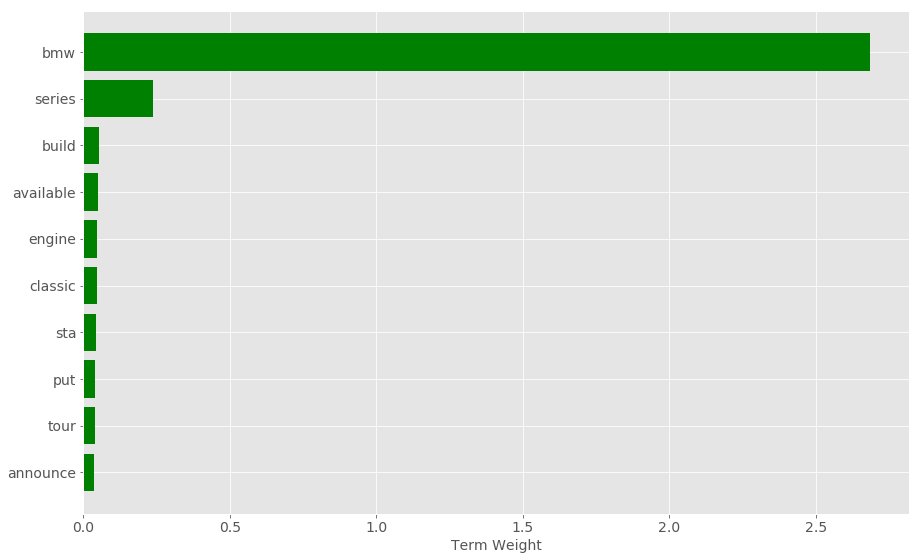

01.  mash bmw have make animal from the to the m 
02.  magnet the bmw x m on be to die for 
03.  very disappoint with bmw would not recommend anymore shrewsbury shropshire 
04.  bmw diff restoration rebuild measure pinion bear preload via 
05.  bmw be actually lazy when it come to interior 
06.  bmw m concept 
07.  bmw x valet bmwx x bmw pvdapproved ukdetailing bristol airpo 
08.  flair bmw x valet bmwx x bmw pvdapproved ukdetailing bristol airpo 
09.  bmw apps 
10.  bmw i km subject to confirmation r pvamaindale 


Total:  500
Percent Positive:  8.4
Percent Negative:  1.6
Percent Neutral:  90.0


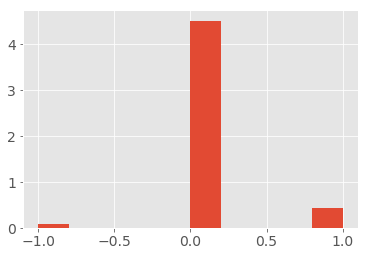

In [38]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

topic = 5

def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()
    
    
plot_top_term_weights( terms, H, topic, 10 )    


# Let us look now at the most relevant posts for each topic

def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

topic_snippets = get_top_snippets( snippets, W, topic, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s " % ( (i+1), snippet) )
    
    
# Now we carry out some sentiment analysis using TEXTBLOB
from textblob import TextBlob
import collections

sentiment_polarity_data= []
sentiment_subjectivity_data= []

topic_snippets = get_top_snippets( snippets, W, topic, 500 )
for i, snippet in enumerate(topic_snippets):
    snippet_polarity_score =  TextBlob(snippet).sentiment.polarity # Polarity, [1]= subjectivity
    snippet_subjectivity_score = TextBlob(snippet).sentiment.subjectivity
    
    if(snippet_polarity_score>=0.5):
        sentiment_polarity_data.append(1.0)
    elif(snippet_polarity_score<=-0.5):
        sentiment_polarity_data.append(-1.0)
    else:
        sentiment_polarity_data.append(0.0)

    
sentiment_polarity_data = np.asarray(sentiment_polarity_data)
sentiment_subjectivity_data = np.asarray(sentiment_subjectivity_data)

print('\n')
print('Total: ', len(sentiment_polarity_data))
print("Percent Positive: ", collections.Counter(sentiment_polarity_data)[1]/len(sentiment_polarity_data)*100.0 )
print("Percent Negative: ", collections.Counter(sentiment_polarity_data)[-1]/len(sentiment_polarity_data)*100.0 )
print("Percent Neutral: ", collections.Counter(sentiment_polarity_data)[0]/len(sentiment_polarity_data)*100.0 )


plt.clf()
plt.hist(sentiment_polarity_data,density=True)
#plt.hist(sentiment_subjectivity_data)
plt.show()